# MindInsight训练看板

[![下载Notebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_notebook.png)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/master/notebook/mindinsight/mindspore_mindinsight_dashboard.ipynb)&emsp;[![查看源文件](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_source.png)](https://gitee.com/mindspore/docs/blob/master/docs/notebook/mindinsight/mindinsight_dashboard.ipynb)

通过MindSpore可以将训练过程中的标量、图像、参数分布直方图、张量、计算图和数据图记录到summary日志文件中，并通过MindInsight提供的可视化界面进行查看。

- 通过查看特定的标量数值随着训练步骤的变化趋势，比如查看每个迭代的损失值、正确率、准确率这些标量的变化过程，追踪神经网络在整个训练过程中的信息，帮助用户了解模型是否过拟合，或者是否训练了过长时间。可以通过比较不同训练中的这些指标，以帮助调试和改善模型。

- 通过查看训练过程中的图像数据，用户可以查看每个步骤所使用的数据集图像。

- 参数分布直方图支持以直方图的形式呈现Tensor的变化趋势，用户可以查看训练过程中每个训练步骤的权重、bias和梯度参数变化信息。

- 张量可视能够帮助用户直观查看训练过程中某个步骤的Tensor值，Tensor包括权重值、梯度值、激活值等。

- 计算图的生成是通过将模型训练过程中的每个计算节点关联后所构成的，用户可以通过查看计算图，掌握整个模型的计算走向结构，数据流以及控制流的信息。对于高阶的使用人员，能够通过计算图验证计算节点的输入输出是否正确，并验证整个计算过程是否符合预期。

- 数据图展示的是数据预处理的过程，在MindInsight可视化面板中可查看数据处理的图，能够更加直观地查看数据预处理的每一个环节，并帮助提升模型性能。

接下来是本次流程的体验过程。

## 整体流程

1. 下载CIFAR-10二进制格式数据集。
2. 对数据进行预处理。
3. 定义AlexNet网络。
4. 训练网络，使用 `SummaryCollector` 记录损失值标量、权重梯度、计算图和数据图参数。
5. 完成训练后，查看MindInsight看板中记录到的损失值标量、直方图、图像信息、张量、计算图、数据图信息。
6. 关闭MindInsight服务。

## 准备环节

### 下载数据集

本次流程使用CIFAR-10二进制格式数据集，下载地址为：<https://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz>。

CIFAR-10二进制格式数据集包含10个类别的60000个32x32彩色图像。每个类别6000个图像，包含50000张训练图像和10000张测试图像。数据集分为5个训练批次和1个测试批次，每个批次具有10000张图像。测试批次包含每个类别中1000个随机选择的图像，训练批次按随机顺序包含剩余图像（某个训练批次包含的一类图像可能比另一类更多）。其中，每个训练批次精确地包含对应每个类别的5000张图像。

执行下面一段代码下载CIFAR-10二进制格式数据集到当前工作目录，如果已经下载过数据集，则不重复下载。

In [ ]:
import os
import requests
import tarfile
import zipfile
import shutil

requests.packages.urllib3.disable_warnings()

def download_dataset(url, target_path):
    """下载并解压数据集"""
    if not os.path.exists(target_path):
        os.makedirs(target_path)
    download_file = url.split("/")[-1]
    if not os.path.exists(download_file):
        res = requests.get(url, stream=True, verify=False)
        if download_file.split(".")[-1] not in ["tgz", "zip", "tar", "gz"]:
            download_file = os.path.join(target_path, download_file)
        with open(download_file, "wb") as f:
            for chunk in res.iter_content(chunk_size=512):
                if chunk:
                    f.write(chunk)
    if download_file.endswith("zip"):
        z = zipfile.ZipFile(download_file, "r")
        z.extractall(path=target_path)
        z.close()
    if download_file.endswith(".tar.gz") or download_file.endswith(".tar") or download_file.endswith(".tgz"):
        t = tarfile.open(download_file)
        names = t.getnames()
        for name in names:
            t.extract(name, target_path)
        t.close()
    print("The {} file is downloaded and saved in the path {} after processing".format(os.path.basename(url), target_path))

download_dataset("https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/cifar-10-binary.tar.gz", "./datasets")
test_path = "./datasets/cifar10/test"
train_path = "./datasets/cifar10/train"
os.makedirs(test_path, exist_ok=True)
os.makedirs(train_path, exist_ok=True)
if not os.path.exists(os.path.join(test_path, "test_batch.bin")):
    shutil.move("./datasets/cifar-10-batches-bin/test_batch.bin", test_path)
[shutil.move("./datasets/cifar-10-batches-bin/"+i, train_path) for i in os.listdir("./datasets/cifar-10-batches-bin/") if os.path.isfile("./datasets/cifar-10-batches-bin/"+i) and not i.endswith(".html") and not os.path.exists(os.path.join(train_path, i))]

下载数据集后，CIFAR-10数据集目录（`datasets`）结构如下所示。

```text
    $ tree datasets
    datasets
    └── cifar10
        ├── test
        │   └── test_batch.bin
        └── train
            ├── data_batch_1.bin
            ├── data_batch_2.bin
            ├── data_batch_3.bin
            ├── data_batch_4.bin
            └── data_batch_5.bin
```

其中：

- `test_batch.bin`文件为测试数据集文件。
- `data_batch_1.bin`文件为第1批次训练数据集文件。
- `data_batch_2.bin`文件为第2批次训练数据集文件。
- `data_batch_3.bin`文件为第3批次训练数据集文件。
- `data_batch_4.bin`文件为第4批次训练数据集文件。
- `data_batch_5.bin`文件为第5批次训练数据集文件。

## 数据处理

好的数据集可以有效提高训练精度和效率，在加载数据集前，会进行一些处理，增加数据的可用性和随机性。下面一段代码定义函数`create_dataset_cifar10`来进行数据处理操作，并创建训练数据集(`ds_train`)和测试数据集(`ds_eval`)。

In [1]:
import mindspore.dataset as ds
import mindspore.dataset.transforms.c_transforms as C
import mindspore.dataset.vision.c_transforms as CV
from mindspore import dtype as mstype


def create_dataset_cifar10(data_path, batch_size=32, repeat_size=1, status="train"):
    """
    create dataset for train or test
    """
    cifar_ds = ds.Cifar10Dataset(data_path)
    rescale = 1.0 / 255.0
    shift = 0.0

    resize_op = CV.Resize(size=(227, 227))
    rescale_op = CV.Rescale(rescale, shift)
    normalize_op = CV.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    if status == "train":
        random_crop_op = CV.RandomCrop([32, 32], [4, 4, 4, 4])
        random_horizontal_op = CV.RandomHorizontalFlip()
    channel_swap_op = CV.HWC2CHW()
    typecast_op = C.TypeCast(mstype.int32)
    cifar_ds = cifar_ds.map(operations=typecast_op, input_columns="label")
    if status == "train":
        cifar_ds = cifar_ds.map(operations=random_crop_op, input_columns="image")
        cifar_ds = cifar_ds.map(operations=random_horizontal_op, input_columns="image")
    cifar_ds = cifar_ds.map(operations=resize_op, input_columns="image")
    cifar_ds = cifar_ds.map(operations=rescale_op, input_columns="image")
    cifar_ds = cifar_ds.map(operations=normalize_op, input_columns="image")
    cifar_ds = cifar_ds.map(operations=channel_swap_op, input_columns="image")

    cifar_ds = cifar_ds.shuffle(buffer_size=1000)
    cifar_ds = cifar_ds.batch(batch_size, drop_remainder=True)
    cifar_ds = cifar_ds.repeat(repeat_size)
    return cifar_ds

ds_train = create_dataset_cifar10(data_path="./datasets/cifar10/train")
ds_eval = create_dataset_cifar10("./datasets/cifar10/test")

### 抽取数据集图像

执行以下一段代码，抽取上步创建好的训练数据集`ds_train`中第一个`batch`的32张图像以及对应的类别名称进行展示。

The 32 images with label of the first batch in ds_train are showed below:


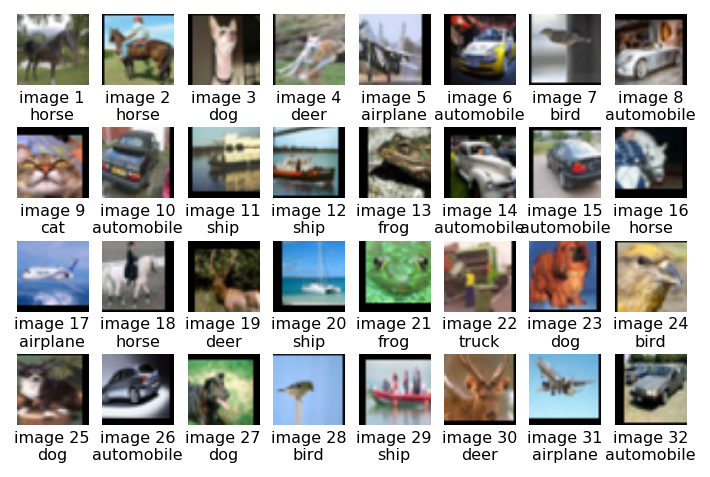

In [2]:
from matplotlib import pyplot as plt
import numpy as np

label_list = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
print("The 32 images with label of the first batch in ds_train are showed below:")
ds_iterator = ds_train.create_dict_iterator()
next(ds_iterator)
batch_1 = next(ds_iterator)
batch_image = batch_1["image"].asnumpy()
batch_label = batch_1["label"].asnumpy()
%matplotlib inline
plt.figure(dpi=144)
for i, image in enumerate(batch_image):
    plt.subplot(4, 8, i+1)
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    image = image/np.amax(image)
    image = np.clip(image, 0, 1)
    image = np.transpose(image, (1, 2, 0))
    plt.imshow(image)
    num = batch_label[i]
    plt.title(f"image {i+1}\n{label_list[num]}", y=-0.65, fontdict={"fontsize": 8})
    plt.axis('off')
plt.show()

## 定义训练网络

在进行训练之前，需定义神经网络模型，本流程采用AlexNet网络。

以下一段代码中定义AlexNet网络结构。

In [3]:
import mindspore.nn as nn
from mindspore.common.initializer import TruncatedNormal
import mindspore.ops as ops

def conv(in_channels, out_channels, kernel_size, stride=1, padding=0, pad_mode="valid"):
    weight = weight_variable()
    return nn.Conv2d(in_channels, out_channels,
                     kernel_size=kernel_size, stride=stride, padding=padding,
                     weight_init=weight, has_bias=False, pad_mode=pad_mode)

def fc_with_initialize(input_channels, out_channels):
    weight = weight_variable()
    bias = weight_variable()
    return nn.Dense(input_channels, out_channels, weight, bias)

def weight_variable():
    return TruncatedNormal(0.02)


class AlexNet(nn.Cell):
    """
    Alexnet
    """
    def __init__(self, num_classes=10, channel=3):
        super(AlexNet, self).__init__()
        self.conv1 = conv(channel, 96, 11, stride=4)
        self.conv2 = conv(96, 256, 5, pad_mode="same")
        self.conv3 = conv(256, 384, 3, pad_mode="same")
        self.conv4 = conv(384, 384, 3, pad_mode="same")
        self.conv5 = conv(384, 256, 3, pad_mode="same")
        self.relu = nn.ReLU()
        self.max_pool2d = ops.MaxPool(kernel_size=3, strides=2)
        self.flatten = nn.Flatten()
        self.fc1 = fc_with_initialize(6*6*256, 4096)
        self.fc2 = fc_with_initialize(4096, 4096)
        self.fc3 = fc_with_initialize(4096, num_classes)

    def construct(self, x):
        x = self.max_pool2d(self.relu(self.conv1(x)))
        x = self.max_pool2d(self.relu(self.conv2(x)))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.max_pool2d(self.relu(self.conv5(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### 导入模块

In [5]:
import os
import mindspore.nn as nn
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor, TimeMonitor
from mindspore.nn import Accuracy
from mindspore.train.callback import SummaryCollector
from mindspore import Tensor, set_context, GRAPH_MODE, Model

device_target = "GPU"
set_context(mode=GRAPH_MODE, device_target=device_target)

### 定义学习率

设置一个动态学习率，按照前80%的step以设置的最大学习率（lr_max）进行训练，后20%的step按照0.1倍最大学习率进行训练。

以下一段代码定义学习率。

In [6]:
import numpy as np


def get_lr(current_step, lr_max, total_epochs, steps_per_epoch):
    """
    generate learning rate array

    Args:
       current_step(int): current steps of the training
       lr_max(float): max learning rate
       total_epochs(int): total epoch of training
       steps_per_epoch(int): steps of one epoch

    Returns:
       np.array, learning rate array
    """
    lr_each_step = []
    total_steps = steps_per_epoch * total_epochs
    decay_epoch_index = [0.8 * total_steps]
    for i in range(total_steps):
        if i < decay_epoch_index[0]:
            lr = lr_max
        else:
            lr = lr_max * 0.1
        lr_each_step.append(lr)
    lr_each_step = np.array(lr_each_step).astype(np.float32)
    learning_rate = lr_each_step[current_step:]

    return learning_rate


参数解释：

- `current_step`：动态学习率的起始step。
- `lr_max`：动态学习率中的最大学习率。
- `total_epochs`：训练的epoch数。
- `steps_per_epoch`：每个epoch中训练的step数。

### 执行训练

在执行训练过程中，使用回调函数[SummaryCollector](https://www.mindspore.cn/docs/zh-CN/master/api_python/mindspore.train.html#mindspore.train.callback.SummaryCollector)自动收集Summary数据。并将其采集的数据存储在路径`./summary_dir/summary_01`中。

In [7]:
from mindspore.train.callback import SummaryCollector

network = AlexNet(num_classes=10)
net_loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction="mean")
lr = Tensor(get_lr(0, 0.002, 10, ds_train.get_dataset_size()))
net_opt = nn.Momentum(network.trainable_params(), learning_rate=lr, momentum=0.9)
time_cb = TimeMonitor(data_size=ds_train.get_dataset_size())
config_ck = CheckpointConfig(save_checkpoint_steps=1562, keep_checkpoint_max=10)
ckpoint_cb = ModelCheckpoint(directory="./models/ckpt/mindinsight_dashboard", prefix="checkpoint_alexnet", config=config_ck)
model = Model(network, net_loss, net_opt, metrics={"Accuracy": Accuracy()})

summary_collector = SummaryCollector(summary_dir='./summary_dir/summary_01', collect_freq=20)

print("============== Starting Training ==============")
model.train(epoch=5, train_dataset=ds_train, callbacks=[time_cb, ckpoint_cb, LossMonitor(), summary_collector], dataset_sink_mode=False)

============== Starting Training ==============
epoch: 1 step: 1, loss is 2.2925508
epoch: 1 step: 2, loss is 2.3099365
... ...
epoch: 1 step: 1559, loss is 1.4238389
epoch: 1 step: 1560, loss is 1.8238091
epoch: 1 step: 1561, loss is 1.4984075
epoch: 1 step: 1562, loss is 1.5537517
epoch time: 129742.093 ms, per step time: 83.062 ms
epoch: 2 step: 1, loss is 1.4230748
epoch: 2 step: 2, loss is 1.5858011
... ...
epoch: 2 step: 1559, loss is 1.5705462
epoch: 2 step: 1560, loss is 1.7115651
epoch: 2 step: 1561, loss is 1.1751521
epoch: 2 step: 1562, loss is 1.4915059
epoch time: 83402.194 ms, per step time: 53.394 ms
epoch: 3 step: 1, loss is 1.4695673
epoch: 3 step: 2, loss is 1.4559203
... ...
epoch: 5 step: 1559, loss is 0.61639774
epoch: 5 step: 1560, loss is 1.2703929
epoch: 5 step: 1561, loss is 0.69596004
epoch: 5 step: 1562, loss is 0.66120243
epoch time: 78220.526 ms, per step time: 50.077 ms


> 更多的Summary数据收集方式可以参考官方文档《[收集Summary数据](https://www.mindspore.cn/mindinsight/docs/zh-CN/master/summary_record.html)》。
>
> 收集Summary数据时，需将训练过程中的数据下层模式关闭，即`dataset_sink_mode=False`。更多注意事项可参考[官网文档](https://www.mindspore.cn/mindinsight/docs/zh-CN/master/summary_record.html#注意事项)。

## 执行验证

训练完成后，对模型进行验证。在验证过程中，也能使用`SummaryCollector`对验证过程中的数据。

In [9]:
print("============== Starting Testing ==============")
acc = model.eval(ds_eval, callbacks=summary_collector, dataset_sink_mode=False)
print("============== {} ==============".format(acc))

============== Starting Testing ==============
============== {'Accuracy': 0.6949118589743589} ==============


## 启动MindInsight服务

在ModelArts中或者Notebook中可以运行以下代码启动MindInsight。

其中：`--port`为开启的MindInsight的服务端口，默认为8080，可以设置为1~65535任意数值，此处设置为8000。`--summary-base-dir`为Summary数据的存放路径。

> 训练看板的各个模块的使用方法可以参考官方文档介绍：《[查看训练看板](https://www.mindspore.cn/mindinsight/docs/zh-CN/master/dashboard.html)》。
>
> 更多的MindInsight命令可以参考《[MindInsight相关命令](https://www.mindspore.cn/mindinsight/docs/zh-CN/master/mindinsight_commands.html)》

In [1]:
%reload_ext mindinsight
%mindinsight --port 8000 --summary-base-dir ./summary_dir

Launching MindInsight in Notebook...

mindinsight start on port 8000


## 关闭MindInsight服务

在终端命令行中执行以下代码关闭MindInsight服务。

```bash
mindinsight stop --port 8000
```

> 关闭Mindinsight服务时，端口数值需与开启时的端口数值一致。

## MindInsight训练看板

进入到可视化面板。

![Mindinsight Panel](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/docs/notebook/mindinsight/images/mindinsight_panel.png)

在上图所示面板中可以看到`summary_01`日志文件目录，点击**训练看板**进入到下图所示的训练数据展示面板，该面板展示了标量数据、直方图、图像和张量信息，并随着训练、测试的进行实时刷新数据，实时显示训练过程参数的变化情况。

![Mindinsight Panel2](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/docs/notebook/mindinsight/images/mindinsight_panel2.png)

### 标量可视化

标量可视化用于展示训练过程中标量的变化趋势，点击打开训练标量信息展示面板，该面板记录了迭代计算过程中的损失值标量信息，如下图展示了损失值标量趋势图。

![Scalar Panel](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/docs/notebook/mindinsight/images/scalar_panel.png)

上图展示了神经网络在训练过程中损失值的变化过程。横坐标是训练步骤，纵坐标是损失值。

图中右上角有几个按钮功能，从左到右功能分别是全屏展示，切换Y轴比例，开启/关闭框选，分步回退和还原图形。

- 全屏展示即全屏展示该标量曲线，再点击一次即可恢复。
- 切换Y轴比例是指可以将Y轴坐标进行对数转换。
- 开启/关闭框选是指可以框选图中部分区域，并放大查看该区域，可以在已放大的图形上叠加框选。
- 分步回退是指对同一个区域连续框选并放大查看时，可以逐步撤销操作。
- 还原图形是指进行了多次框选后，点击此按钮可以将图还原回原始状态。

![Scalar Select](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/docs/notebook/mindinsight/images/scalar_select.png)

上图展示的标量可视化的功能区，提供了根据选择不同标签，水平轴的不同维度和平滑度来查看标量信息的功能。

- 标签选择：提供了对所有标签进行多项选择的功能，用户可以通过勾选所需的标签，查看对应的标量信息。
- 水平轴：可以选择“步骤”、“相对时间”、“绝对时间”中的任意一项，来作为标量曲线的水平轴。
- 平滑度：可以通过调整平滑度，对标量曲线进行平滑处理。
- 标量合成：可以选中两条标量曲线进行合成并展示在一个图中，以方便对两条曲线进行对比或者查看合成后的图。
  标量合成的功能区与标量可视化的功能区相似。其中与标量可视化功能区不一样的地方，在于标签选择时，标量合成功能最多只能同时选择两个标签，将其曲线合成并展示。

### 直方图可视化

直方图用于将用户所指定的张量以直方图的形式展示。点击打开直方图展示面板，以直方图的形式记录了在迭代过程中所有层参数分布信息。

![Histogram Panel](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/docs/notebook/mindinsight/images/histogram_panel.png)

如下图为`conv1`层参数分布信息，点击图中右上角，可以将图放大。

![Histogram](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/docs/notebook/mindinsight/images/histogram.png)

下图为直方图功能区。

![Histogram Func](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/docs/notebook/mindinsight/images/histogram_func.png)

上图展示直方图的功能区，包含以下内容：

- 标签选择：提供了对所有标签进行多项选择的功能，用户可以通过勾选所需的标签，查看对应的直方图。
- 纵轴：可以选择步骤、相对时间、绝对时间中的任意一项，来作为直方图纵轴显示的数据。
- 视角：可以选择正视和俯视中的一种。正视是指从正面的角度查看直方图，此时不同步骤之间的数据会覆盖在一起。俯视是指偏移以45度角俯视直方图区域，这时可以呈现不同步骤之间数据的差异。

### 图像可视化

图像可视化用于展示用户所指定的图片。点击数据抽样展示面板，展示了每个一步进行处理的图像信息。

下图为展示`summary_01`记录的图像信息。

![Image Panel](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/docs/notebook/mindinsight/images/image_panel.png)

通过滑动上图中的"步骤"滑条，查看不同步骤的图片。

![Image Function](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/docs/notebook/mindinsight/images/image_function.png)

上图展示图像可视化的功能区，提供了选择查看不同标签，不同亮度和不同对比度来查看图片信息。

- 标签：提供了对所有标签进行多项选择的功能，用户可以通过勾选所需的标签，查看对应的图片信息。
- 亮度调整：可以调整所展示的所有图片亮度。
- 对比度调整：可以调整所展示的所有图片对比度。

### 张量可视化

张量可视化用于将张量以表格以及直方图的形式进行展示。

![Tensor Func](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/docs/notebook/mindinsight/images/tensor_func.png)

上图展示了张量可视化的功能区，包含以下内容：

- 标签选择：提供了对所有标签进行多项选择的功能，用户可以通过勾选所需的标签，查看对应的表格数据或者直方图。
- 视图：可以选择表格或者直方图来展示tensor数据。在直方图视图下存在纵轴和视角的功能选择。
- 纵轴：可以选择步骤、相对时间、绝对时间中的任意一项，来作为直方图纵轴显示的数据。
- 视角：可以选择正视和俯视中的一种。正视是指从正面的角度查看直方图，此时不同步骤之间的数据会覆盖在一起。俯视是指 偏移以45度角俯视直方图区域，这时可以呈现不同步骤之间数据的差异。

![](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/docs/notebook/mindinsight/images/tensor.png)

上图中将用户所记录的张量以表格的形式展示，包含以下功能：

- 点击表格右边小方框按钮，可以将表格放大。
- 表格中白色方框显示当前展示的是哪个维度下的张量数据，其中冒号":"表示当前维度的所有值，可以在方框输入对应的索引或者:后按Enter键或者点击后边的打勾按钮来查询特定维度的张量数据。 假设某维度是32，则其索引范围是-32到31。注意：可以查询0维到2维的张量数据，不支持查询超过两维的张量数据，即不能设置超过两个冒号":"的查询条件。
- 拖拽表格下方的空心圆圈可以查询特定步骤的张量数据。

### 计算图可视化

点击计算图可视化用于展示计算图的图结构，数据流以及控制流的走向，支持展示summary日志文件与通过`context`的`save_graphs`参数导出的`pb`文件。

![graph.png](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/docs/notebook/mindinsight/images/caculate_graph.png)

上展示了计算图的网络结构。如图中所展示的，在展示区中，选中其中一个算子（图中圈红算子），可以看到该算子有两个输入和一个输出（实线代表算子的数据流走向）。

![graph-sidebar.png](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/docs/notebook/mindinsight/images/graph_sidebar.png)

上图展示了计算图可视化的功能区，包含以下内容：

- 文件选择框：可以选择查看不同文件的计算图。
- 搜索框：可以对节点进行搜索，输入节点名称点击回车，即可展示该节点。
- 缩略图：展示整个网络图结构的缩略图，在查看超大图结构时，方便查看当前浏览的区域。
- 节点信息：展示选中的节点的基本信息，包括节点的名称、属性、输入节点、输出节点等信息。
- 图例：展示的是计算图中各个图标的含义。

### 数据图可视化

数据图可视化用于展示单次模型训练的数据处理和数据增强信息。

![data-function.png](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/docs/notebook/mindinsight/images/data_function.png)

上图展示的数据图功能区包含以下内容：

- 图例：展示数据溯源图中各个图标的含义。
- 数据处理流水线：展示训练所使用的数据处理流水线，可以选择图中的单个节点查看详细信息。
- 节点信息：展示选中的节点的基本信息，包括使用的数据处理和增强算子的名称、参数等。